# Pixel RNN implementation

This notebook will uses a simpler version of the PixelRNN architecture called PixelCNN, which just relies on a series of masked convolutions.

In [ ]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from helpers.utils import *
from helpers.ops import *
from helpers.statistic import Statistic

### setting the hyperparameters

All the hyperparameters for the model are set in this cell, this includes hyperparameters, datasets.

In [3]:
hyperparams = {# network
    "model" : "pixel_cnn", # name of model [pixel_rnn, pixel_cnn]
    "batch_size" : 100, # size of a batch
    "hidden_dims" : 16, # dimesion of hidden states of LSTM or Conv layers
    "recurrent_length" : 7, # the length of LSTM or Conv layers
    "out_hidden_dims" : 32, # dimesion of hidden states of output Conv layers
    "out_recurrent_length" : 2, # the length of output Conv layers
    "use_residual" : False, # whether to use residual connections or not
    "use_dynamic_rnn" : False, # whether to use dynamic_rnn or not

    # training
    "max_epoch" : 20, # # of step in an epoch
    "test_step" : 10, # # of step to test a model
    "save_step" : 5, # # of step to save a model
    "learning_rate" : 1e-3, # learning rate
    "grad_clip" : 1, # value of gradient to be used for clipping
    "use_gpu" : True, # whether to use gpu for training

    # data
    "data" : "mnist", # name of dataset 
    "data_dir" : "MNIST-data", # name of data directory
    "sample_dir" : "samples", # name of sample directory

    # Debug
    "is_train" : True, # training or testing
    "display" : False, # whether to display the training results or not
    "random_seed" :  123 # random seed for python
}
p = dotdict(hyperparams)

In [4]:
if "random_seed" in p:
    tf.set_random_seed(p.random_seed)
    np.random.seed(p.random_seed)

### Loading the dataset

In [5]:
model_dir = setup_model_saving(p.model, p.data, hyperparams)
DATA_DIR = p.data_dir
SAMPLE_DIR = os.path.join(model_dir, p.sample_dir)

check_and_create_dir(DATA_DIR)
check_and_create_dir(SAMPLE_DIR)

# prepare dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

next_train_batch = lambda x: mnist.train.next_batch(x)[0]
next_test_batch = lambda x: mnist.test.next_batch(x)[0]

height, width, channel = 28, 28, 1

train_step_per_epoch = mnist.train.num_examples // p.batch_size
test_step_per_epoch = mnist.test.num_examples // p.batch_size

print('dir_path : ', model_dir)
#plt.imshow(mnist.train[0], cmap=plt.cm.binary)

W1211 19:28:31.912906 39616 deprecation.py:323] From <ipython-input-5-953da0aff043>:10: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1211 19:28:31.918890 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1211 19:28:31.926871 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed

Extracting MNIST-data\train-images-idx3-ubyte.gz


W1211 19:28:32.596915 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST-data\train-labels-idx1-ubyte.gz


W1211 19:28:32.615866 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Extracting MNIST-data\t10k-labels-idx1-ubyte.gz


W1211 19:28:32.740530 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


dir_path :  run/mnist\pixel_cnn2


### Building the network

Let's construct the PixelCNN model. First, we set up input placeholder. We'll be feeding batches of training images into the model through this.

Next, we construct the masked convolutional layers. You can find the implementation of this masking procedure in ops.py. These layers apply a series of convolutions to the image, where each filter is masked to only account for pixels in the region of interest. These are the pixels above and to the left of the pixel in the center of the mask, which follows the PixelRNN generative model assumptions. Also of note is that the receptive field of the PixelCNN model grows linearly with the depth of these convolutional stacks.

After the convolutions, we apply a sigmoid activation to arrive at an estimate for the grayscale intensity for each pixel in the output image.

In [6]:
def pixelCNN(height, width, channel, params):
    """
    Args
    height, width, channel - the dimensions of the input
    params -- the hyperparameters of the network
    """
    input_shape = [None, height, width, channel] if params.use_gpu else [None, channel, height, width]
    inputs = tf.placeholder(tf.float32, input_shape)
    
    print("Started building Pixel CNN : ")
    
    # input of main convolutional layers
    scope = "conv_inputs"
    conv_inputs = conv2d(inputs, params.hidden_dims, [7, 7], "A", scope=scope)
    
    # main convolutions layers
    last_hid = conv_inputs
    for idx in range(params.recurrent_length):
        scope = 'CONV%d' % idx
        last_hid = conv2d(last_hid, 3, [1, 1], "B", scope=scope)
        print("Building %s" % scope)

    # output convolutional layers
    for idx in range(params.out_recurrent_length):
        scope = 'CONV_OUT%d' % idx
        last_hid = tf.nn.relu(conv2d(last_hid, params.out_hidden_dims, [1, 1], "B", scope=scope))
        print("Building %s" % scope)

    conv2d_out_logits = conv2d(last_hid, 1, [1, 1], "B", scope='conv2d_out_logits')
    output = tf.nn.sigmoid(conv2d_out_logits)
    return inputs, output, conv2d_out_logits

inputs, output, conv2d_out_logits = pixelCNN(height, width, channel, p)

Started building Pixel CNN : 


W1211 19:28:33.171385 39616 variables.py:2445] Variable *= will be deprecated. Use `var.assign(var * other)` if you want assignment to the variable value or `x = x * y` if you want a new python Tensor object.


Building CONV0
Building CONV1
Building CONV2
Building CONV3
Building CONV4
Building CONV5
Building CONV6
Building CONV_OUT0
Building CONV_OUT1


### Optimization

Now, let's train the model. To do so, we will minimize the cross entropy loss using an RMSPropOptimizer. We also clip the gradients to help deal with potential exploding gradient problems.

In [7]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=conv2d_out_logits, labels=inputs, name='loss'))

optimizer = tf.train.RMSPropOptimizer(p.learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)

new_grads_and_vars = \
    [(tf.clip_by_value(gv[0], -p.grad_clip, p.grad_clip), gv[1]) for gv in grads_and_vars]
optim = optimizer.apply_gradients(new_grads_and_vars)
 
# show_all_variables()
print("Building %s finished!" % p.model)

W1211 19:28:35.762115 39616 deprecation.py:323] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1211 19:28:36.373516 39616 deprecation.py:506] From C:\Users\hpendyal\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\training\rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Building pixel_cnn finished!


### Image Generation

To generate an image, we predict a single pixel at a time. Once we generate a pixel, the next prediction will use the previous pixels to generate the next pixel intensity using the masked convolutions.

In [8]:

def predict(sess, images, inputs, output):
    return sess.run(output, {inputs: images})
def generate_occlusions(sess, height, width, inputs, output):
    samples = occlude(images, height, width)
    starting_position = [0,height//2]
    for i in range(starting_position[1], height):
        for j in range(starting_position[0], width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]
    return samples

def generate(sess, height, width, inputs, output):
    samples = np.zeros((100, height, width, 1), dtype='float32')

    for i in range(height):
        for j in range(width):
            next_sample = binarize(predict(sess, samples, inputs, output))
            samples[:, i, j] = next_sample[:, i, j]

    return samples

### Training

Now we start the actual training process. We initialize Tensorflow and load a Statistics class to keep track of the model and score statistics as we train.

Then, we go through our training epochs, generating a series of images, evaluating the loss and optimizing accordingly. Every epoch we also test the model by producing sample images and evaluating the performance on some test data. Finally, once training is finished, we generate the images to display.

Start training


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

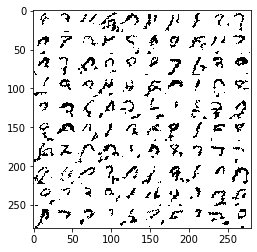

train loss: 0.246, test loss: 0.138:   5%|██▎                                           | 1/20 [01:29<28:23, 89.64s/it]

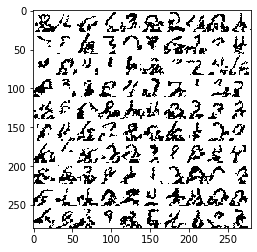

train loss: 0.137, test loss: 0.138:  10%|████▌                                         | 2/20 [02:53<26:23, 87.98s/it]

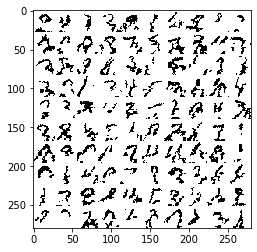

train loss: 0.137, test loss: 0.135:  15%|██████▉                                       | 3/20 [04:19<24:46, 87.46s/it]

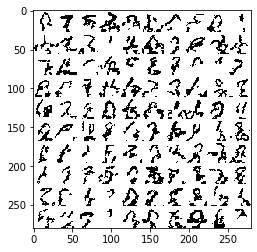

train loss: 0.136, test loss: 0.136:  20%|█████████▏                                    | 4/20 [05:51<23:39, 88.73s/it]

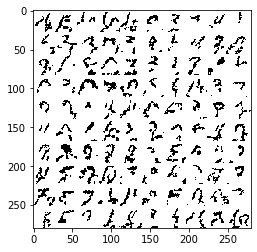

train loss: 0.136, test loss: 0.135:  25%|███████████▌                                  | 5/20 [07:20<22:11, 88.78s/it]

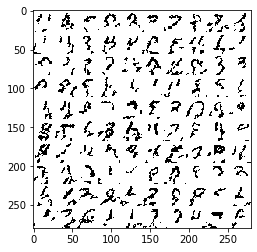

train loss: 0.135, test loss: 0.135:  30%|█████████████▊                                | 6/20 [08:54<21:05, 90.40s/it]

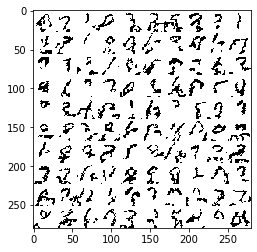

train loss: 0.135, test loss: 0.134:  35%|████████████████                              | 7/20 [10:22<19:26, 89.72s/it]

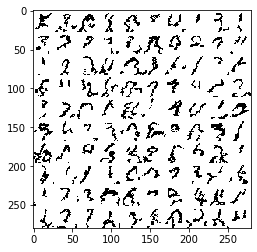

train loss: 0.135, test loss: 0.134:  40%|██████████████████▍                           | 8/20 [11:47<17:38, 88.24s/it]

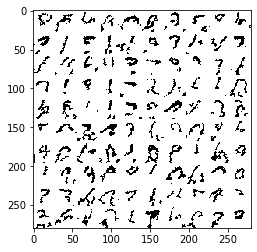

train loss: 0.134, test loss: 0.135:  45%|████████████████████▋                         | 9/20 [13:11<15:57, 87.04s/it]

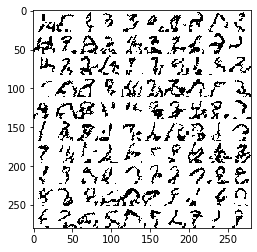

train loss: 0.134, test loss: 0.134:  50%|██████████████████████▌                      | 10/20 [14:36<14:23, 86.32s/it]

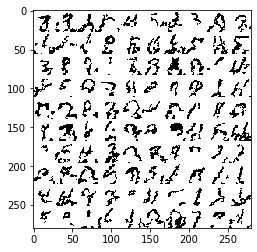

train loss: 0.134, test loss: 0.133:  55%|████████████████████████▊                    | 11/20 [16:07<13:10, 87.84s/it]

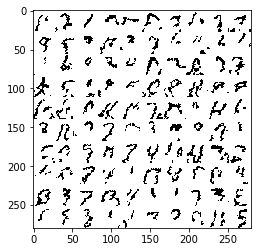

train loss: 0.134, test loss: 0.133:  60%|███████████████████████████                  | 12/20 [17:40<11:54, 89.28s/it]

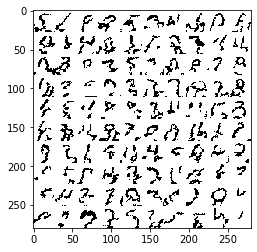

train loss: 0.134, test loss: 0.133:  65%|█████████████████████████████▎               | 13/20 [19:08<10:23, 89.01s/it]

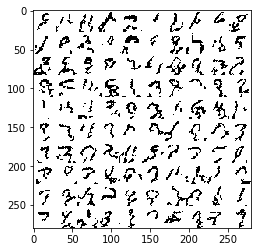

train loss: 0.134, test loss: 0.133:  70%|███████████████████████████████▍             | 14/20 [20:37<08:52, 88.83s/it]

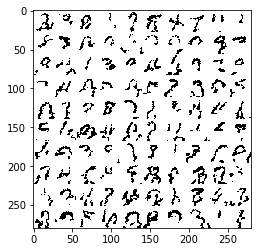

train loss: 0.134, test loss: 0.133:  75%|█████████████████████████████████▊           | 15/20 [22:09<07:29, 89.82s/it]

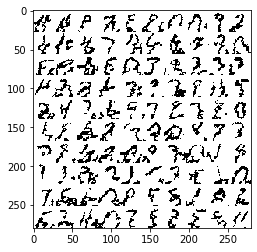

train loss: 0.134, test loss: 0.133:  80%|████████████████████████████████████         | 16/20 [23:37<05:56, 89.24s/it]

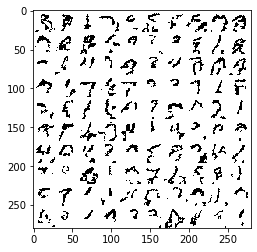

train loss: 0.134, test loss: 0.133:  85%|██████████████████████████████████████▎      | 17/20 [25:05<04:26, 88.76s/it]

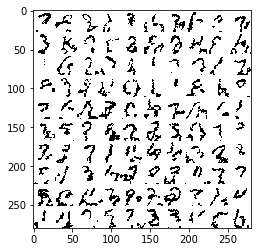

train loss: 0.134, test loss: 0.132:  90%|████████████████████████████████████████▌    | 18/20 [26:33<02:57, 88.52s/it]

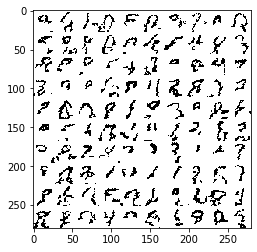

train loss: 0.133, test loss: 0.133:  95%|██████████████████████████████████████████▊  | 19/20 [28:02<01:28, 88.93s/it]

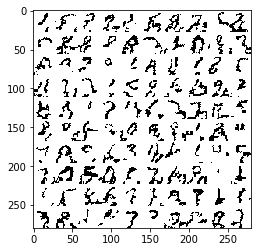

train loss: 0.133, test loss: 0.132: 100%|█████████████████████████████████████████████| 20/20 [29:29<00:00, 88.21s/it]


Wall time: 29min 33s


In [9]:
%%time
sess = tf.Session()
stat = Statistic(sess, p.data, model_dir, tf.trainable_variables(), p.test_step)
stat.load_model()
init = tf.global_variables_initializer()

sess.run(init)
stat.start()
print("Start training")

initial_step = stat.get_t() if stat else 0
# iterator = trange(p.max_epoch, ncols=70, initial=initial_step)
iterator = tqdm(range(p.max_epoch))

for epoch in iterator:
    # print('Start epoch')
    # 1. train
    total_train_costs = []
    for idx in range(train_step_per_epoch):
        images = binarize(next_train_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        _, cost = sess.run([optim, loss], feed_dict={ inputs: images })
        total_train_costs.append(cost)
    # print('Start testing')
    # 2. test
    total_test_costs = []
    for idx in range(test_step_per_epoch):
        images = binarize(next_test_batch(p.batch_size)) \
            .reshape([p.batch_size, height, width, channel])

        cost = sess.run(loss, feed_dict={ inputs : images })
        total_test_costs.append(cost)

    avg_train_cost, avg_test_cost = np.mean(total_train_costs), np.mean(total_test_costs)

    stat.on_step(avg_train_cost, avg_test_cost)
    # print('Start generation')
    # 3. generate samples
    samples = generate_occlusions(sess, height, width, inputs, output)
    path = save_images(samples, height, width, 10, 10, 
        directory=SAMPLE_DIR, prefix="epoch_%s" % epoch)
    iterator.set_description("train loss: %.3f, test loss: %.3f" % (avg_train_cost, avg_test_cost))

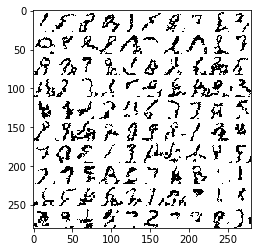

Wall time: 11.7 s


'run/mnist\\pixel_cnn2\\samples\\sample_0.jpg'

In [10]:
%%time
samples = generate_occlusions(sess, height, width, inputs, output)
save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)

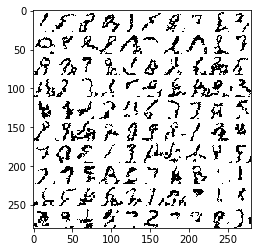

Wall time: 455 ms


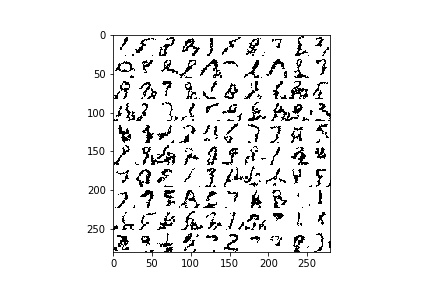

In [11]:
%%time
from IPython.display import Image
fname = save_images(samples, height, width, 10, 10, directory=SAMPLE_DIR)
Image(filename=fname)

In [12]:
sess.close()